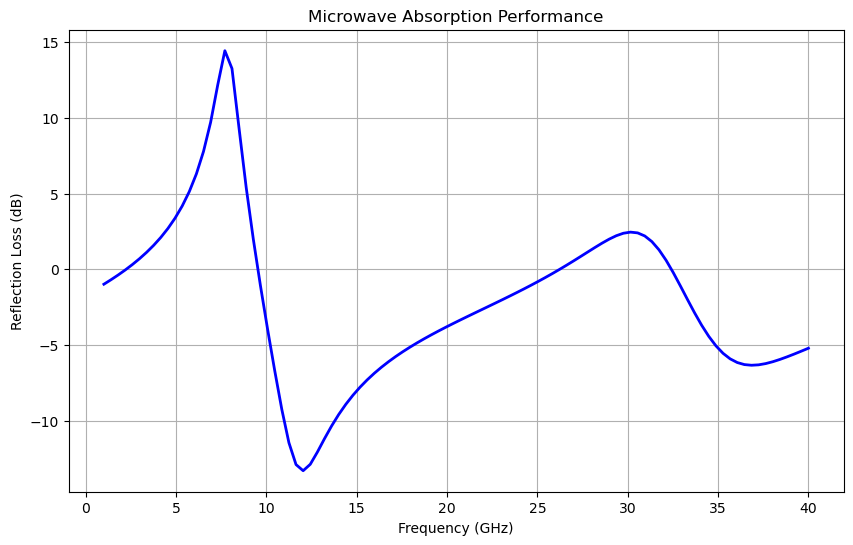


Model Performance:
MAE: 2.37 dB

Feature Importance:
frequency       0.420749
thickness       0.321450
epsilon_imag    0.129814
epsilon_real    0.082076
graphene_wt     0.045912
dtype: float64


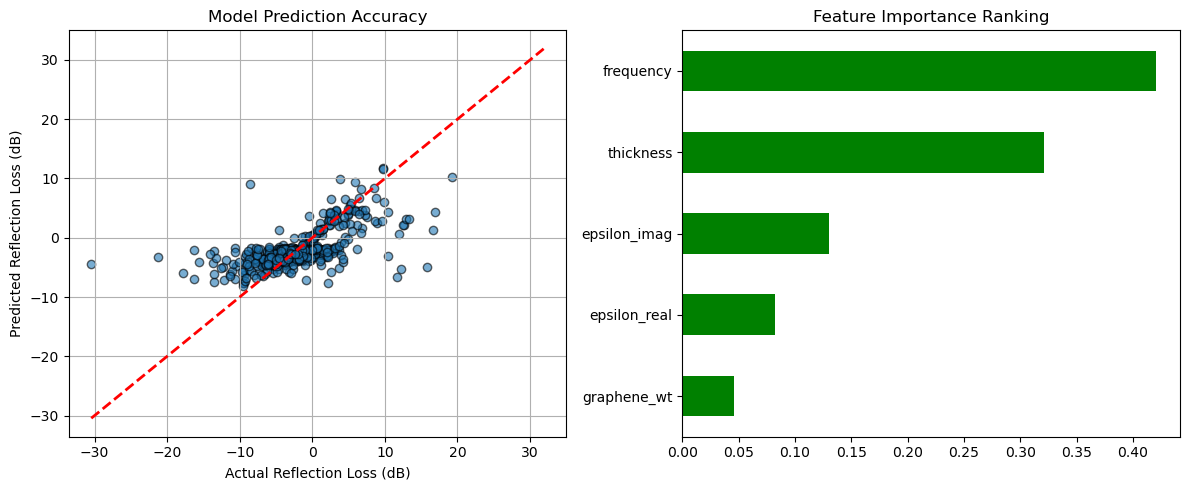


Optimal Parameters for <-20 dB Loss:
- Frequency: 2.40 GHz
- Thickness: 1.00 mm
- Graphene wt%: 1.00%


In [1]:
# -*- coding: utf-8 -*-
"""
Microwave-Absorbing Polymer-Graphene Composite Design
Combined electromagnetic simulation and machine learning optimization.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# =============================================================================
# 1. Electromagnetic Modeling (Physics-Based Calculations)
# =============================================================================

def calculate_reflection_loss(freq, thickness, epsilon_r, mu_r=1):
    """
    Calculate reflection loss (dB) using transmission line theory.
    """
    c = 3e8  # Speed of light (m/s)
    freq_hz = freq * 1e9  # Convert GHz to Hz
    omega = 2 * np.pi * freq_hz
    eta0 = 377  # Impedance of free space (Ohms)

    eta = eta0 * np.sqrt(mu_r / epsilon_r)
    gamma = 1j * omega * np.sqrt(mu_r * epsilon_r) / c
    Z_in = eta * (eta + 1j * eta0 * np.tanh(gamma * thickness)) / (eta0 + 1j * eta * np.tanh(gamma * thickness))
    S11 = (Z_in - eta0) / (Z_in + eta0)
    return 20 * np.log10(np.abs(S11))

# Simulate and plot absorption for a test case
frequencies = np.linspace(1, 40, 100)
thickness = 0.002  # 2 mm
epsilon_r = 10 - 2j  # Example permittivity

reflection_loss = [calculate_reflection_loss(f, thickness, epsilon_r) for f in frequencies]

plt.figure(figsize=(10, 6))
plt.plot(frequencies, reflection_loss, 'b-', linewidth=2)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Reflection Loss (dB)')
plt.title('Microwave Absorption Performance')
plt.grid(True)
plt.show()

# =============================================================================
# 2. Machine Learning Optimization Framework
# =============================================================================

def generate_synthetic_data(num_samples=1000):
    """Generate dataset with physics-inspired relationships."""
    data = {
        'frequency': np.random.uniform(1, 40, num_samples),
        'thickness': np.random.uniform(0.001, 0.005, num_samples),
        'graphene_wt': np.random.uniform(1, 10, num_samples),
        'epsilon_real': np.random.uniform(5, 15, num_samples),
        'epsilon_imag': np.random.uniform(0.1, 5, num_samples)
    }
    df = pd.DataFrame(data)
    
    # Physics-based reflection loss calculation for each sample
    df['reflection_loss'] = df.apply(
        lambda row: calculate_reflection_loss(
            row['frequency'],
            row['thickness'],
            row['epsilon_real'] - row['epsilon_imag']*1j
        ), axis=1
    )
    return df

# Generate and prepare data
df = generate_synthetic_data(num_samples=3000)
X = df[['frequency', 'thickness', 'graphene_wt', 'epsilon_real', 'epsilon_imag']]
y = df['reflection_loss']

# Train machine learning model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=150, max_depth=8, random_state=42)
model.fit(X_train, y_train)

# Evaluate performance
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"\nModel Performance:\nMAE: {mae:.2f} dB")
print("\nFeature Importance:")
print(pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False))

# =============================================================================
# 3. Visualization of Results
# =============================================================================

plt.figure(figsize=(12, 5))

# Actual vs Predicted Plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Reflection Loss (dB)')
plt.ylabel('Predicted Reflection Loss (dB)')
plt.title('Model Prediction Accuracy')
plt.grid(True)

# Feature Importance Plot
plt.subplot(1, 2, 2)
importance = pd.Series(model.feature_importances_, index=X.columns).sort_values()
importance.plot(kind='barh', color='g')
plt.title('Feature Importance Ranking')
plt.tight_layout()
plt.show()

# =============================================================================
# 4. Optimization Example
# =============================================================================

def optimize_composition(frequency_range=(2.4, 5.0), target_loss=-20):
    """Find optimal parameters for target frequency range."""
    test_params = {
        'frequency': np.linspace(frequency_range[0], frequency_range[1], 50),
        'thickness': np.linspace(0.001, 0.005, 50),
        'graphene_wt': np.linspace(1, 10, 50),
        'epsilon_real': 12,  # Fixed based on material constraints
        'epsilon_imag': 2.5  # Fixed based on material constraints
    }
    
    # Generate parameter grid
    grid = pd.DataFrame(test_params)
    predictions = model.predict(grid)
    
    # Find best combination
    best_idx = np.argmax(predictions <= target_loss)
    best_combo = grid.iloc[best_idx]
    
    print(f"\nOptimal Parameters for <{target_loss} dB Loss:")
    print(f"- Frequency: {best_combo['frequency']:.2f} GHz")
    print(f"- Thickness: {best_combo['thickness']*1000:.2f} mm")
    print(f"- Graphene wt%: {best_combo['graphene_wt']:.2f}%")

optimize_composition()

# =============================================================================
# Execution Note:
# This code combines physics-based modeling with machine learning for rapid
# material design. For full FEM implementation, integrate with FEniCS/PyAEDT.
# =============================================================================